In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/My \ Drive/NLP/Project/Text_Summarization

/content/drive/My  Drive/NLP/Project/Text_Summarization


In [3]:
#%cd drive/My \ Drive/Text_Summarization

In [4]:
!pwd

/content/drive/My  Drive/NLP/Project/Text_Summarization


## The below common code is borrowed from the EDA.ipynb.

In [5]:
import json
import pandas as pd
import numpy as np
import re

In [6]:
with open("./Data/telehealth_article_texts.txt") as f:
    #Skip header
    for i in range(4):
        next(f) 
    corpus = f.read()

In [7]:
dict_articles = json.loads(corpus.replace("\n",""))

In [8]:
df_articles = pd.DataFrame.from_dict(dict_articles,orient="index",columns=["Content"]).reset_index().drop(columns=["index"])

In [9]:
df_articles.head()

,Content
0,Veterans face a variety of stressors related t...
1,The impact of the COVID-19 pandemic on the chi...
2,"In November 2019, COVID-19—the infectious, hig..."
3,Anxiety and depressive disorders are among the...
4,"In mid-March, 2020, the authors—as well as the..."


In [10]:
df_metadata = pd.read_excel("Data/Metadata_telehealth_article_key_2.25.xlsx",index_col="Index")
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation
Index,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea..."
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca..."
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar..."
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)...."


In [11]:
#Ensure both Indexes are of same type before merge
assert df_metadata.index.dtype == df_articles.index.dtype

#Merge dataframes
df_metadata = df_metadata.merge(df_articles,left_index=True,right_index=True,how="left")

In [12]:
df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content
Index,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig..."
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the..."


In [13]:
def clean_text(text,lowercase=False):
    
    corpus =  text

    punc = string.punctuation.replace("-","")
    
    if lowercase:
        corpus = text.lower()

    translator = str.maketrans(" "," ",punc)
    
    clean_corpus = corpus.translate(translator)
    
    remove_extra_whitespaces = [token.strip() for token in clean_corpus.split()]

    return " ".join(remove_extra_whitespaces)





In [14]:
df_metadata["Content_Length"] = df_metadata["Content"].apply(lambda text: len(text))
df_metadata["Abstract_Length"] = df_metadata["Abstract"].apply(lambda text: len(str(text)))
df_metadata["Parsed_Keywords"] = df_metadata["Keywords"].apply(lambda keywords: str(keywords).replace("\n\n"," ").split(" ")[1:])
df_metadata["Parsed_Keywords_Length"] = df_metadata["Parsed_Keywords"].apply(lambda text: len(text))


#Have an idea of reference amount per document
df_metadata["et_al_Count"] = df_metadata["Content"].apply(lambda text: len(list(re.finditer("et al",text))))


In [15]:
import string

In [16]:
df_metadata["Clean_Content"] = df_metadata["Content"].apply(lambda text: clean_text(text,lowercase=False))
df_metadata["Clean_Content_length"] = df_metadata["Clean_Content"].apply(lambda text: len(text))

df_metadata.head()

,Journal Title,Article Title,Date Published,Authors,Abstract,Keywords,Citation,Content,Content_Length,Abstract_Length,Parsed_Keywords,Parsed_Keywords_Length,et_al_Count,Clean_Content,Clean_Content_length
Index,,,,,,,,,,,,,,,
0,Psychological Servies,The Effectiveness of Telepsychology With Veter...,2021,Michael J. McClellan; Richard Osbaldiston; Ron...,Veterans face a variety of stressors due to th...,"KEYWORDS:\n\ntelepsychology, meta-analysis, ve...","McClellan, M. J., Osbaldiston, R., Wu, R., Yea...",Veterans face a variety of stressors related t...,37477,2411,"[telepsychology,, meta-analysis,, veteran,, vi...",5,50,Veterans face a variety of stressors related t...,36423
1,"Psychology, Public Policy, and Law",Making the Case for Videoconferencing and Remo...,2021,Milfred D. Dale; Desiree Smith,The COVID-19 pandemic and its requirements for...,"KEYWORDS:\n\nremote child custody evaluations,...","Dale, M. D., & Smith, D. (2021). Making the ca...",The impact of the COVID-19 pandemic on the chi...,74025,1577,"[remote, child, custody, evaluations,, videoco...",10,48,The impact of the COVID-19 pandemic on the chi...,72009
2,"Psychology, Public Policy, and Law","Forensic E-Mental Health: Review, Research Pri...",2021,Lauren E. Kois; Jennifer Cox; Ashley T. Peck,Forensic e-mental health is an area of psychol...,"KEYWORDS:\n\nforensic e-mental health, telehea...","Kois, L. E., Cox, J., & Peck, A. T. (2021). Fo...","In November 2019, COVID-19—the infectious, hig...",63568,1842,"[forensic, e-mental, health,, telehealth,, tel...",8,128,In November 2019 COVID-19—the infectious highl...,61640
3,Training and Education in Professional Psychology,Moving Toward a New Era of Telepsychology in U...,2021,Allison L. Baier; Sarah Danzo,Many university training clinics are facing nu...,"KEYWORDS:\n\neducation and training, telepsych...","Baier, A. L., & Danzo, S. (2021). Moving towar...",Anxiety and depressive disorders are among the...,30147,1650,"[education, and, training,, telepsychology,, C...",6,21,Anxiety and depressive disorders are among the...,29392
4,Practice Innovations,Navigating Changes in the Physical and Psychol...,2021,Liat Shklarski; Allison Abrams; Elana Bakst,The emergence of the Covid-19 pandemic at the ...,"KEYWORDS:\n\nremote psychotherapy, Covid-19, p...","Shklarski, L., Abrams, A., & Bakst, E. (2021)....","In mid-March, 2020, the authors—as well as the...",42367,1871,"[remote, psychotherapy,, Covid-19,, pandemic,,...",6,14,In mid-March 2020 the authors—as well as the m...,41383


## **Topic Modeling**

In [17]:
debug=False

In [18]:
from gensim.parsing.preprocessing import preprocess_documents
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import strip_numeric
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_short
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
# Retrieve an array of cleaned document text corpus
text_corpus = df_metadata["Clean_Content"].values

**Customized gensim preprocess_documents without stemming:**

In [20]:
def preprocess_documents_without_stem(docs):

  filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]
  return [preprocess_string(d, filters) for d in docs]

**Function for building a dictionary and preprocess a list or array of document texts:**

In [21]:
def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  #tokenized_texts = preprocess_documents(text_corpus)
  tokenized_texts = preprocess_documents_without_stem(text_corpus)
  
  # Create a dictionary
  dictionary = Dictionary(tokenized_texts)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

  return dictionary, bow_corpus, tokenized_texts

**Function for computing coherence score of a LSI model or LDA model by give number of topics:**

In [22]:
# coherence_type can be 'u_mass' or 'c_v'
# algorithm can be 'LSI' or 'LDA'
def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

**Function for generating coherece scores of LSI model or LDA model by given minimum and maximum number of topics.  The coherence scores and the best number of topics are returned:**

In [23]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='u_mass'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score <= min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score >= max_score:
        max_score = score
        best_num_topics= k


  return coherence_scores, best_num_topics

**Function for plotting coherece scores:**

In [24]:
import matplotlib.pyplot as plt
import matplotlib.style as style
#%matplotlib inline

def plot_coherence_scores(min_topics, max_topics, coherence_scores, coherence_type, algorithm):
  style.use('fivethirtyeight')

  x = [int(i) for i in range(min_topics, max_topics)]

  plt.figure(figsize=(10,8))
  plt.plot(x, coherence_scores)
  plt.xlabel('Number of topics')
  plt.ylabel('Coherence Value')
  plt.title(algorithm + ' Coherence Scores by number of Topics (' + coherence_type + ')')

**Function for printing topics of a LSI model or LDA mode, it also returns that model:**

In [25]:
def print_topics(dictionary, num_topics, algorithm, num_words=10, friendly_print=True):
  
  if algorithm == 'LSI':
    model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

  if friendly_print:
    # Extract terms from results returned by show_topic()
    for topic_number in range(0, num_topics):
      terms = []
      for term, wt in model.show_topic(topic_number, num_words):
        terms.append(term)
    
      print('Topic ' + str(topic_number) + ':', terms)

  else:
    topics = model.print_topics(num_topics, num_words)
    for topic in topics:
      print(topic)

  return model

**Create a dictionary and BOW coprpus:**

In [26]:
dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(text_corpus)

In [27]:
len(tokenized_texts)

44

## Latent Semantic Analysis (LSA) or Latent Semantic Indexing (LSI): Use Singular Value Decomposition (SVD) algorithm to extract hidden topics in corpus.

**Note: We can use perplexity and coherence scores as measures to evaluate the topic model. Typically, lower the perplexity, the better the model. Similarly, the lower the UMass score and the higher the Cv score in coherence, the better the model.**

**Here, we attempt to find the best number of topics by computing and comparing coherence scores of the LSI model:**

In [28]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass, best_num_topics_u_mass = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LSI', coherence_type='u_mass')


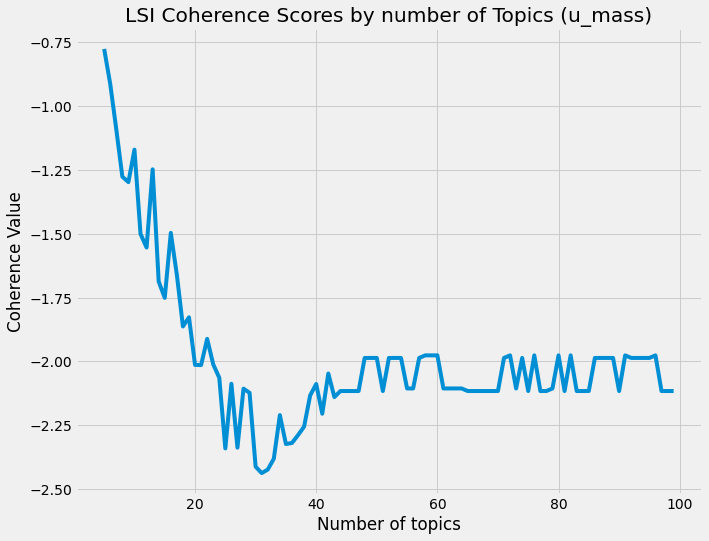

In [29]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass, coherence_type='u_mass', algorithm='LSI')

In [30]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass)

The best number of topics found by u-mass coherence score: 31


In [31]:
# c_v is much slower
min_topics, max_topics = 5, 100
coherence_scores_c_v, best_num_topics_c_v = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LSI', coherence_type='c_v')


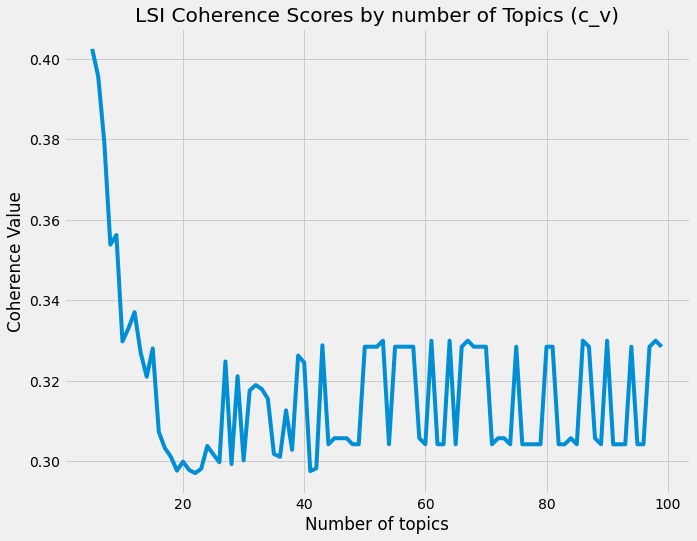

In [32]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_c_v, coherence_type='c_v', algorithm='LSI')

In [33]:
print('The best number of topics found by c-v coherence score:', best_num_topics_c_v)

The best number of topics found by c-v coherence score: 5


**Print the topics (based on the best u-mass score):**

In [34]:
lsi_model = print_topics(dictionary, best_num_topics_u_mass, algorithm='LSI', num_words=15, friendly_print=True)

Topic 0: ['health', 'telepsychology', 'care', 'mental', 'services', 'treatment', 'use', 'training', 'psychologists', 'practice', 'based', 'technology', 'person', 'clinical', 'research']
Topic 1: ['telepsychology', 'health', 'mental', 'care', 'training', 'psychologists', 'practice', 'telemental', 'trainees', 'clients', 'clinics', 'clinic', 'forensic', 'veterans', 'pandemic']
Topic 2: ['tmh', 'providers', 'health', 'mental', 'hub', 'patients', 'forensic', 'telepsychology', 'veterans', 'attitudes', 'studies', 'care', 'articles', 'nyh', 'experience']
Topic 3: ['care', 'training', 'clinics', 'health', 'treatment', 'trainees', 'veterans', 'clinic', 'telepsychology', 'data', 'forensic', 'supervisors', 'face', 'based', 'participants']
Topic 4: ['telepsychology', 'studies', 'clients', 'delivered', 'training', 'data', 'effect', 'treatment', 'veterans', 'information', 'ptsd', 'client', 'apa', 'technology', 'trainees']
Topic 5: ['psychologists', 'training', 'practice', 'telepsychology', 'trainees'

In [35]:
print_topics(dictionary, best_num_topics_u_mass, algorithm='LSI', num_words=15, friendly_print=False)

(0, '0.432*"health" + 0.250*"telepsychology" + 0.238*"care" + 0.221*"mental" + 0.192*"services" + 0.165*"treatment" + 0.162*"use" + 0.130*"training" + 0.118*"psychologists" + 0.113*"practice" + 0.107*"based" + 0.107*"technology" + 0.103*"person" + 0.102*"clinical" + 0.100*"research"')
(1, '-0.583*"telepsychology" + 0.429*"health" + 0.241*"mental" + 0.228*"care" + -0.210*"training" + -0.188*"psychologists" + -0.138*"practice" + 0.120*"telemental" + -0.115*"trainees" + -0.111*"clients" + -0.108*"clinics" + -0.104*"clinic" + 0.090*"forensic" + 0.089*"veterans" + -0.085*"pandemic"')
(2, '0.677*"tmh" + 0.295*"providers" + -0.268*"health" + -0.202*"mental" + 0.180*"hub" + 0.148*"patients" + -0.139*"forensic" + -0.116*"telepsychology" + 0.110*"veterans" + 0.103*"attitudes" + 0.099*"studies" + 0.093*"care" + 0.075*"articles" + 0.075*"nyh" + 0.074*"experience"')
(3, '-0.326*"care" + -0.250*"training" + -0.241*"clinics" + -0.184*"health" + 0.169*"treatment" + -0.166*"trainees" + -0.154*"veterans

**Print the topics (based on the best c-v score):**

In [36]:
print_topics(dictionary, best_num_topics_c_v, algorithm='LSI', num_words=15, friendly_print=True)

Topic 0: ['health', 'telepsychology', 'care', 'mental', 'services', 'treatment', 'use', 'training', 'psychologists', 'practice', 'based', 'technology', 'person', 'clinical', 'research']
Topic 1: ['telepsychology', 'health', 'mental', 'care', 'training', 'psychologists', 'practice', 'telemental', 'trainees', 'clients', 'clinics', 'clinic', 'forensic', 'veterans', 'pandemic']
Topic 2: ['tmh', 'providers', 'health', 'mental', 'hub', 'patients', 'forensic', 'telepsychology', 'veterans', 'attitudes', 'studies', 'care', 'articles', 'nyh', 'experience']
Topic 3: ['care', 'training', 'clinics', 'health', 'treatment', 'trainees', 'veterans', 'clinic', 'telepsychology', 'data', 'forensic', 'supervisors', 'face', 'based', 'participants']
Topic 4: ['telepsychology', 'studies', 'clients', 'delivered', 'training', 'data', 'effect', 'treatment', 'veterans', 'information', 'ptsd', 'client', 'apa', 'technology', 'trainees']


In [37]:
print_topics(dictionary, best_num_topics_c_v, algorithm='LSI', num_words=15, friendly_print=False)

(0, '0.432*"health" + 0.250*"telepsychology" + 0.238*"care" + 0.221*"mental" + 0.192*"services" + 0.165*"treatment" + 0.162*"use" + 0.130*"training" + 0.118*"psychologists" + 0.113*"practice" + 0.107*"based" + 0.107*"technology" + 0.103*"person" + 0.102*"clinical" + 0.100*"research"')
(1, '-0.583*"telepsychology" + 0.429*"health" + 0.241*"mental" + 0.228*"care" + -0.210*"training" + -0.188*"psychologists" + -0.138*"practice" + 0.120*"telemental" + -0.115*"trainees" + -0.111*"clients" + -0.108*"clinics" + -0.104*"clinic" + 0.090*"forensic" + 0.089*"veterans" + -0.085*"pandemic"')
(2, '-0.677*"tmh" + -0.295*"providers" + 0.268*"health" + 0.202*"mental" + -0.180*"hub" + -0.148*"patients" + 0.139*"forensic" + 0.116*"telepsychology" + -0.110*"veterans" + -0.103*"attitudes" + -0.099*"studies" + -0.093*"care" + -0.075*"articles" + -0.075*"nyh" + -0.074*"experience"')
(3, '0.326*"care" + 0.250*"training" + 0.241*"clinics" + 0.184*"health" + -0.169*"treatment" + 0.166*"trainees" + 0.154*"vetera

## Latent Dirichlet Allocation (LDA)

In [38]:
min_topics, max_topics = 5, 100
coherence_scores_u_mass, best_num_topics_u_mass = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='u_mass')


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


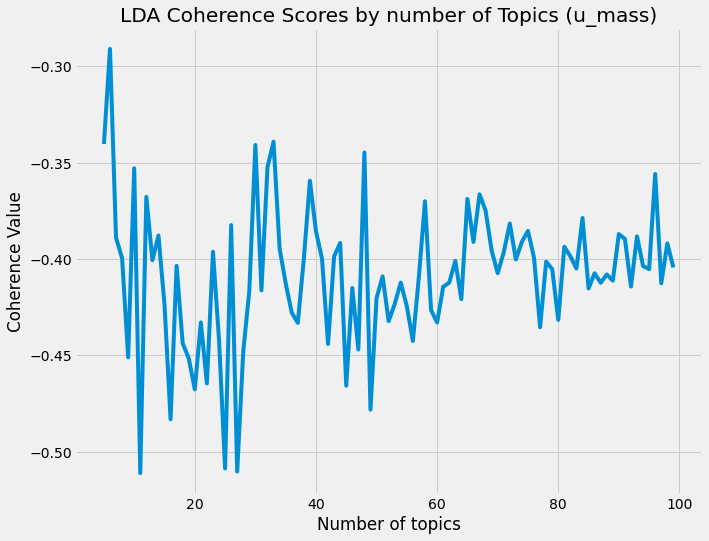

In [39]:
plot_coherence_scores(min_topics, max_topics, coherence_scores_u_mass, coherence_type='u_mass', algorithm='LDA')

In [40]:
print('The best number of topics found by u-mass coherence score:', best_num_topics_u_mass)

The best number of topics found by u-mass coherence score: 11


In [41]:
lda_model = print_topics(dictionary, best_num_topics_u_mass, algorithm='LDA', num_words=15, friendly_print=True)

Topic 0: ['health', 'telepsychology', 'care', 'telesupervision', 'training', 'based', 'person', 'face', 'mental', 'supervision', 'clinicians', 'delivered', 'trainees', 'studies', 'treatment']
Topic 1: ['training', 'telepsychology', 'health', 'services', 'trainees', 'care', 'clients', 'clinics', 'access', 'clinical', 'data', 'based', 'use', 'psychologists', 'practice']
Topic 2: ['health', 'treatment', 'care', 'based', 'pcit', 'veterans', 'mental', 'services', 'use', 'tmh', 'time', 'technology', 'clinic', 'patient', 'help']
Topic 3: ['health', 'telepsychology', 'mental', 'practice', 'psychologists', 'training', 'participants', 'use', 'care', 'research', 'technology', 'services', 'treatment', 'data', 'based']
Topic 4: ['health', 'mental', 'care', 'treatment', 'forensic', 'use', 'research', 'telepsychology', 'technology', 'practice', 'services', 'rural', 'veterans', 'community', 'providers']
Topic 5: ['tmh', 'health', 'care', 'providers', 'use', 'telepsychology', 'treatment', 'services', '

In [42]:
print_topics(dictionary, best_num_topics_u_mass, algorithm='LDA', num_words=15, friendly_print=False)

(0, '0.005*"treatment" + 0.005*"health" + 0.005*"telepsychology" + 0.004*"use" + 0.004*"services" + 0.004*"care" + 0.004*"practice" + 0.003*"mental" + 0.003*"pandemic" + 0.003*"technology" + 0.003*"person" + 0.003*"covid" + 0.003*"participants" + 0.003*"clinical" + 0.003*"training"')
(1, '0.020*"health" + 0.014*"care" + 0.009*"mental" + 0.008*"training" + 0.007*"telepsychology" + 0.006*"services" + 0.005*"use" + 0.005*"clinics" + 0.005*"treatment" + 0.004*"veterans" + 0.004*"providers" + 0.004*"tmh" + 0.004*"trainees" + 0.004*"rural" + 0.004*"clinic"')
(2, '0.011*"health" + 0.005*"services" + 0.005*"tbh" + 0.005*"mental" + 0.005*"care" + 0.005*"treatment" + 0.003*"clients" + 0.003*"use" + 0.003*"technology" + 0.003*"telepsychology" + 0.003*"person" + 0.003*"practice" + 0.003*"based" + 0.003*"training" + 0.003*"professional"')
(3, '0.008*"telepsychology" + 0.007*"health" + 0.006*"practice" + 0.006*"psychologists" + 0.006*"services" + 0.006*"use" + 0.005*"training" + 0.005*"data" + 0.005

**LDA model perplexity score**

In [43]:
perplexity = lda_model.log_perplexity(bow_corpus)

print('LDA model Perplexity:', perplexity)

LDA model Perplexity: -8.440657063899588


In [44]:
if(debug):
  print(tokenized_texts)
  print(list(dictionary.items()))
  print(bow_corpus)
  print(len(bow_corpus))